In [1]:
import numpy as np
import h5py
import ccfj
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import yaml
import os

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import mathlib
from toollib_standard import plotlib

In [3]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/repartrition_01-03/'               # Harmon server
name_project

'project_repartition_v4.0/output_repar_v9.2_01-01/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.2_01-01/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
key_subworks = info_basic['key_subworks']

In [7]:
dir_image = dir_project+info_basic['dir_image']
dir_stack = dir_project+info_basic['dir_stack']

In [8]:
t = info_basic_bi['t']
f = info_basic_bi['f']
dt = 1/np.max(f)
t = (np.linspace(-len(f)-1,len(f)-1,2*(len(f)-1))+0.5)*dt/2

In [9]:
def time_window_filter(t,ncfst0,r,v_min,t0,a):
    ncfst = ncfst0.copy()
    for i in range(len(ncfst)):
        tag = r[i]/v_min
        #print(t0,tag)
        t1 = t[t>-tag-t0][t[t>-tag-t0]< tag+t0]
        start = np.where(t == t1[0])[0][0]
        end = np.where(t == t1[-1])[0][0]
        ncfst[i][start:end+1]= ncfst[i][start:end+1]* np.exp(-a*np.abs((tag-np.abs(t1))))
    return ncfst

In [10]:
def cut(key_subwork):
    global flag_save 
    global info_basic
    global info_basic_bi
    global key_subworks
    global v_tag
    global t0
    global a
    global dir_project
    global dir_stack

    f = info_basic_bi['f']
    dt = 1/np.max(f)
    t = np.linspace(-len(f)-1,len(f)-1,2*(len(f)-1))*dt/2
    t = (np.linspace(-len(f)-1,len(f)-1,2*(len(f)-1))+0.5)*dt/2

    inname = str(key_subwork)+'_gather_linear.h5'
    outname = str(key_subwork)+'_gather_timewindow.h5'
    ncffile_in = h5py.File(dir_stack + inname,'r')
    if os.path.exists(dir_stack+outname):
        os.remove(dir_stack+outname)
    ncffile = h5py.File(dir_stack+outname,'w')

    ncfs_sum_linear = ncffile_in['ncfs'][:]
    r = ncffile_in['r'][:]

    ncfst_linear = mathlib.freq_time(ncfs_sum_linear)
    ncfst1 = time_window_filter(t,ncfst_linear,r,v_tag,t0,a)
    ncfs_sum_remove = mathlib.time_freq(ncfst1)

    ncffile.create_dataset('ncfs', data=ncfs_sum_remove) 
    ncffile.create_dataset('r',data=r)
    ncffile.close()  
    ncffile_in.close()  

    print(str(key_subwork)+' is done! ' + str(key_subworks.index(key_subwork)+1) + '/' + str(len(key_subworks)))

In [11]:
def remove_zorocor(v_tag,t0,a,dir_project,key_subwork_sample = [],nThreads = 1):
    filename = dir_project+'Basic_info.yml'
    with open(filename, 'r', encoding='utf-8') as f:
        info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
    filename_bi = dir_project+'Basic_info.npy'
    info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary
    key_subworks = info_basic['key_subworks']

    if key_subwork_sample != []:
        key_subworks = key_subwork_sample

    if nThreads == 1:
        for key_subwork in key_subworks:
            cut(key_subwork)
    else:
        pool = ThreadPoolExecutor(max_workers = nThreads)
        for key_subwork in key_subworks:
            pool.submit(cut,key_subwork)
        pool.shutdown()

In [12]:
v_tag = 2
a = 100
t0 = 0.01
#tag = 0.00055
#a = 0.5
key_subwork_sample = [key_subworks[0]]
remove_zorocor(v_tag,t0,a,dir_project,key_subwork_sample)

1--08-03 is done! 1/597


In [13]:
info_basic['v_tag'] = v_tag
info_basic['t0'] = t0
info_basic['a'] = a
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)

In [14]:
key_subwork = key_subwork_sample[0]
outname = str(key_subwork)+'_gather_linear.h5'
ncffile = h5py.File(dir_stack + outname,'r')
outname = str(key_subwork)+'_gather_timewindow.h5'
ncffile_2 = h5py.File(dir_stack + outname,'r')
ncfs_sum_linear_remove = ncffile_2['ncfs'][:]
ncfst_linear_remove = mathlib.freq_time(ncfs_sum_linear_remove)
ncfs_sum_linear = ncffile['ncfs'][:]
ncfst_linear = mathlib.freq_time(ncfs_sum_linear)
r = ncffile['r'][:]
ncffile.close()
ncffile_2.close()

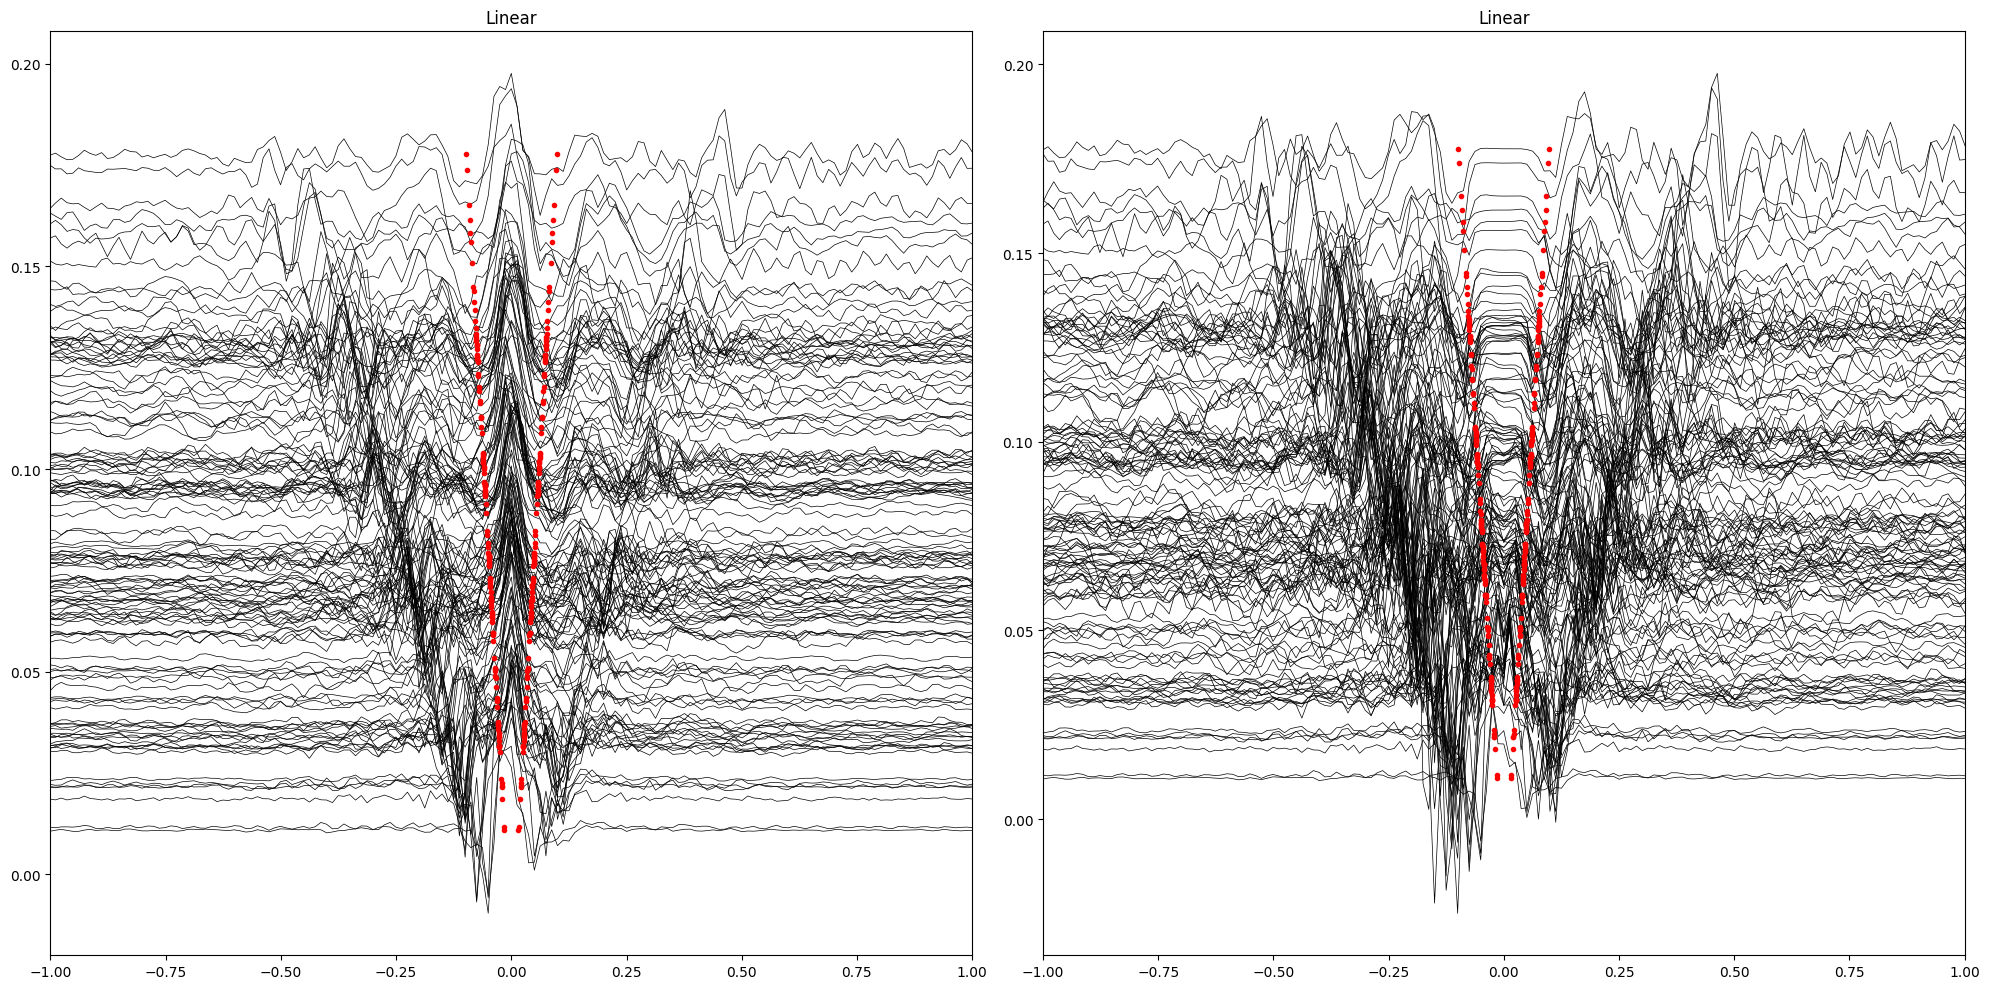

In [15]:
fig,ax = plt.subplots(1,2,figsize = (20,10))

start = info_basic['start']
interval = info_basic['interval']
flag_time = info_basic['flag_time']
xlim_T = [-1,1]
title1 = 'Linear'
ax[0] = plotlib.plot_ncfst(ax[0],t,ncfst_linear[start::interval],r[start::interval],title1,flag_time,xlim_T,0)
#ax[0].vlines(tag,0,0.2,linestyles='dashed',colors='g')
#ax[0].vlines(-tag,0,0.2,linestyles='dashed',colors='g')
ax[1] = plotlib.plot_ncfst(ax[1],t,ncfst_linear_remove[start::interval],r[start::interval],title1,flag_time,xlim_T,0)
#ax[1].vlines(tag,0,0.2,linestyles='dashed',colors='g')
#ax[1].vlines(-tag,0,0.2,linestyles='dashed',colors='g')
for i in range(0,len(r),interval):
    ax[0].plot(t0+r[i]/v_tag,r[i],'r.')
    ax[0].plot(-t0-r[i]/v_tag,r[i],'r.')
    ax[1].plot(t0+r[i]/v_tag,r[i],'r.')
    ax[1].plot(-t0-r[i]/v_tag,r[i],'r.')
plt.tight_layout()
plt.show()